In [3]:
from astroquery.gaia import Gaia
import numpy as np
import matplotlib.pyplot as plt

## Gaia Nearby Stars: First Exploration

Goal:
Query Gaia DR3 for nearby stars and construct a basic
Color–Magnitude Diagram to identify stellar populations.

In [4]:
query = """
SELECT TOP 1000
    source_id,
    ra,
    dec,
    parallax,
    parallax_error,
    phot_g_mean_mag,
    bp_rp
FROM gaiadr3.gaia_source
WHERE parallax > 5
"""
job = Gaia.launch_job(query)
results = job.get_results()

len(results)

1000

In [5]:
results.colnames
results[:5]

source_id,ra,dec,parallax,parallax_error,phot_g_mean_mag,bp_rp
,deg,deg,mas,mas,mag,mag
int64,float64,float64,float64,float32,float32,float32
320718093802368,44.74536901303269,1.0773950153983158,6.531837516382235,0.017344039,10.044208,0.7852421
550447304258304,44.79588627642886,2.0810457896532406,6.086675673256644,0.035279285,15.383587,2.3790636
583054696059392,46.303562089568544,1.4556487221932426,11.407273455939103,0.08725079,16.580158,3.2336245
640710336995072,46.128743548909256,1.725257074618689,5.7687712749591595,0.05386916,16.127031,2.5860262
768494203684224,47.571800043187416,2.556381532771415,5.0099411658666355,1.7005705,20.679522,1.9684887


In [6]:
mask = (
    np.isfinite(results['parallax']) &
    np.isfinite(results['phot_g_mean_mag']) &
    np.isfinite(results['bp_rp'])
)

clean = results[mask]
len(clean)

978

In [7]:
parallax = clean['parallax']  # mas
distance_pc = 1000 / parallax

G = clean['phot_g_mean_mag']
abs_G = G - 5 * np.log10(distance_pc) + 5

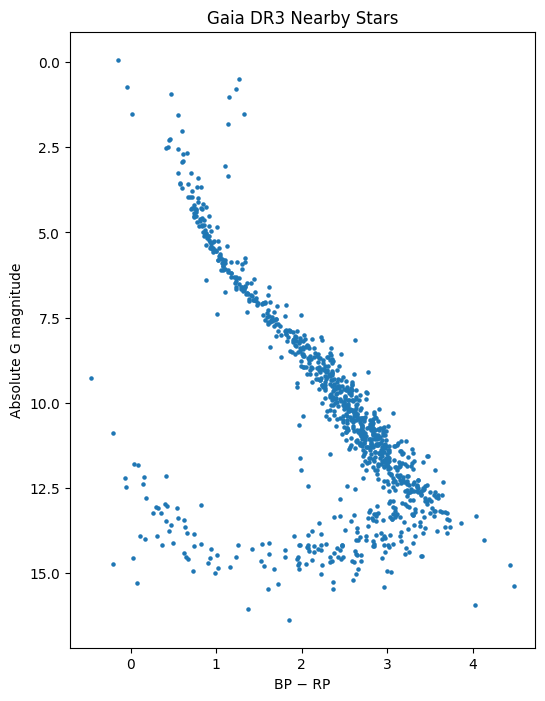

In [8]:
plt.figure(figsize=(6,8))
plt.scatter(clean['bp_rp'], abs_G, s=5)
plt.gca().invert_yaxis()
plt.xlabel('BP − RP')
plt.ylabel('Absolute G magnitude')
plt.title('Gaia DR3 Nearby Stars')
plt.show()